In [1]:
import javabridge
import os
import glob
import pandas as pd
import pydot
from IPython.display import SVG

In [2]:
tetrad_libdir = os.path.join(os.getcwd(), '../../','src', 'pycausal', 'lib')
for l in glob.glob(tetrad_libdir + os.sep + "*.jar"):
    print (l)
    javabridge.JARS.append(str(l))

/home/jovyan/py-causal/example/javabridge/../../src/pycausal/lib/causal-cmd-1.0.0-jar-with-dependencies.jar


In [3]:
javabridge.start_vm(run_headless=True, max_heap_size = '100M')
javabridge.attach()

In [4]:
data_dir = os.path.join(os.getcwd(), '../../','data', 'charity.txt')
data_dir

'/home/jovyan/py-causal/example/javabridge/../../data/charity.txt'

In [5]:
df = pd.read_table(data_dir, sep="\t")
df.head()

,TangibilityCondition,AmountDonated,Sympathy,Imaginability,Impact
0,1.0,0.0,7.0,4.0,4.5
1,1.0,0.0,2.0,2.0,2.0
2,1.0,0.0,7.0,3.0,3.0
3,1.0,0.0,4.0,3.0,4.5
4,1.0,0.0,3.0,7.0,1.0


In [6]:
numCategoriesToDiscretize = 4
node_list = javabridge.JClassWrapper('java.util.ArrayList')()
cont_list = []
disc_list = []
col_no = 0
for col in df.columns:

    cat_array = sorted(set(df[col]))
    if(len(cat_array) > numCategoriesToDiscretize):
        # Continuous variable
        nodi = javabridge.JClassWrapper('edu.cmu.tetrad.data.ContinuousVariable')(col)
        node_list.add(nodi)

        cont_list.append(col_no)

    else:
        # Discrete variable
        cat_list = javabridge.JClassWrapper('java.util.ArrayList')()
        for cat in cat_array:
            cat = str(cat)
            cat_list.add(cat)

        nodname = javabridge.JClassWrapper('java.lang.String')(col)
        nodi = javabridge.JClassWrapper('edu.cmu.tetrad.data.DiscreteVariable')(nodname,cat_list)
        node_list.add(nodi)

        disc_list.append(col_no)

    col_no = col_no + 1

In [7]:
mixedDataBox = javabridge.JClassWrapper('edu.cmu.tetrad.data.MixedDataBox')(node_list, len(df.index))

In [8]:
for row in df.index:

    for col in cont_list:
        value = javabridge.JClassWrapper('java.lang.Double')(df.iloc[row,col])
        mixedDataBox.set(row,col,value)

    for col in disc_list:
        cat_array = sorted(set(df[df.columns[col]]))
        value = javabridge.JClassWrapper('java.lang.Integer')(cat_array.index(df.iloc[row,col]))
        mixedDataBox.set(row,col,value)

In [9]:
tetradData = javabridge.JClassWrapper('edu.cmu.tetrad.data.BoxDataSet')(mixedDataBox, node_list)

In [10]:
alpha = 0.05
discretize = False
indTest = javabridge.JClassWrapper('edu.cmu.tetrad.search.IndTestConditionalGaussianLRT')(tetradData, alpha, discretize)

In [11]:
rfci = javabridge.JClassWrapper('edu.cmu.tetrad.search.Rfci')(indTest)

In [12]:
rfci.setDepth(-1)
rfci.setVerbose(True)

In [13]:
prior = javabridge.JClassWrapper('edu.cmu.tetrad.data.Knowledge2')()
prior.setForbidden('TangibilityCondition', 'Impact') # forbidden directed edges
prior.setRequired('Sympathy','TangibilityCondition') # required directed edges
prior.setTierForbiddenWithin(0, True)
prior.addToTier(0, 'TangibilityCondition')
prior.addToTier(0, 'Imaginability')
prior.addToTier(1, 'Sympathy')
prior.addToTier(1, 'AmountDonated')
prior.addToTier(2, 'Impact')
rfci.setKnowledge(prior)
prior

Instance of edu.cmu.tetrad.data.Knowledge2: /knowledge
addtemporal

1*  Imaginability TangibilityCondition
2  AmountDonated Sympathy
3  Impact

forbiddirect
TangibilityCondition Impact

requiredirect
Sympathy TangibilityCondition

In [14]:
tetradGraph = rfci.search()
tetradGraph

Instance of edu.cmu.tetrad.graph.EdgeListGraphSingleConnections: Graph Nodes:
TangibilityCondition;AmountDonated;Sympathy;Imaginability;Impact

Graph Edges:
1. Sympathy --> TangibilityCondition dd nl
2. AmountDonated o-> Impact
3. AmountDonated o-> Sympathy
4. Imaginability o-> Impact
5. Imaginability o-> Sympathy
6. Sympathy o-> Impact


In [15]:
tetradGraph.toString()

'Graph Nodes:\nTangibilityCondition;AmountDonated;Sympathy;Imaginability;Impact\n\nGraph Edges:\n1. Sympathy --> TangibilityCondition dd nl\n2. AmountDonated o-> Impact\n3. AmountDonated o-> Sympathy\n4. Imaginability o-> Impact\n5. Imaginability o-> Sympathy\n6. Sympathy o-> Impact\n\n'

In [16]:
tetradGraph.getNodeNames()

Instance of java.util.ArrayList: [TangibilityCondition, AmountDonated, Sympathy, Imaginability, Impact]

In [17]:
tetradGraph.getEdges()

Instance of java.util.HashSet: [Sympathy o-> Impact, Sympathy --> TangibilityCondition dd nl, AmountDonated o-> Sympathy, Imaginability o-> Sympathy, AmountDonated o-> Impact, Imaginability o-> Impact]

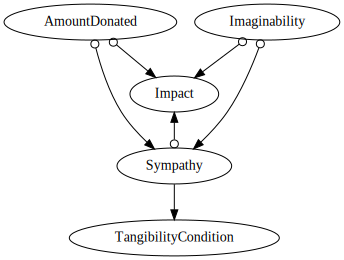

In [18]:
dot_str = javabridge.static_call('edu/cmu/tetrad/graph/GraphUtils',
                                   'graphToDot',
                                   '(Ledu/cmu/tetrad/graph/Graph;)Ljava/lang/String;', 
                                   tetradGraph)
graphs = pydot.graph_from_dot_data(dot_str)
svg_str = graphs[0].create_svg()
SVG(svg_str)

In [19]:
javabridge.detach()
javabridge.kill_vm()